In [14]:
#Load the important libraries neede

import numpy as np # linear algebra
import pandas as pd
import xgboost as xgb
import warnings
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors  import KNeighborsClassifier
import matplotlib.pyplot as plt;
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

In [15]:
#Read data
data = pd.read_csv("./data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

# Display the first few rows of the data
print(data.head())

# Get the shape of the data just to know how many rows and columns it contains
print(data.shape)

             PdId  IncidntNum  Incident Code       Category  \
0   4133422003074    41334220           3074        ROBBERY   
1   5118535807021    51185358           7021  VEHICLE THEFT   
2   4018830907021    40188309           7021  VEHICLE THEFT   
3  11014543126030   110145431          26030          ARSON   
4  10108108004134   101081080           4134        ASSAULT   

                Descript DayOfWeek        Date   Time PdDistrict Resolution  \
0  ROBBERY, BODILY FORCE    Monday  11/22/2004  17:50  INGLESIDE       NONE   
1      STOLEN AUTOMOBILE   Tuesday  10/18/2005  20:00       PARK       NONE   
2      STOLEN AUTOMOBILE    Sunday  02/15/2004  02:00   SOUTHERN       NONE   
3                  ARSON    Friday  02/18/2011  05:27  INGLESIDE       NONE   
4                BATTERY    Sunday  11/21/2010  17:00   SOUTHERN       NONE   

   ... Fix It Zones as of 2017-11-06  2 2  DELETE - HSOC Zones 2 2  \
0  ...                                NaN                      NaN   
1  ...

In [16]:
def transformDataset(dataset):
    
    dataset['Dates'] = pd.to_datetime(dataset['Date'])
    
    dataset['Date'] = dataset['Dates'].dt.date
    
    dataset['n_days'] = (dataset['Date'] - dataset['Date'].min()).apply(lambda x: x.days)
    
    dataset['Year'] = dataset['Dates'].dt.year
    dataset['DayOfWeek'] = dataset['Dates'].dt.dayofweek # OVERWRITE
    dataset['WeekOfYear'] = dataset['Dates'].dt.isocalendar().week
    dataset['Month'] = dataset['Dates'].dt.month
    
    dataset['Hour'] = dataset['Dates'].dt.hour
    
    dataset['Block'] = dataset['Address'].str.contains('block', case=False)
    dataset['Block'] = dataset['Block'].map(lambda x: 1 if  x == True else 0)

    
    dataset = dataset.drop('Dates', axis = 1)
    dataset = dataset.drop('Date', axis = 1)
    dataset = dataset.drop('Address', axis = 1)
    
    district = dataset["PdDistrict"].unique()
    data_dict_district = {}
    count = 1
    
    for data in district:
        data_dict_district[data] = count
        count+=1 
    dataset["PdDistrict"] = dataset["PdDistrict"].replace(data_dict_district)
    
    data_dict = {}
    if "Category" in dataset:
        count = 0
        target = dataset["Category"].unique()
        for data in target:
            data_dict[data] = count
            count+=1
        dataset["Category"] = dataset["Category"].replace(data_dict)

    return dataset


In [17]:
data.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,...,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,4133422003074,41334220,3074,ROBBERY,"ROBBERY, BODILY FORCE",Monday,11/22/2004,17:50,INGLESIDE,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5118535807021,51185358,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,10/18/2005,20:00,PARK,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4018830907021,40188309,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/15/2004,02:00,SOUTHERN,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11014543126030,110145431,26030,ARSON,ARSON,Friday,02/18/2011,05:27,INGLESIDE,NONE,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,94.0
4,10108108004134,101081080,4134,ASSAULT,BATTERY,Sunday,11/21/2010,17:00,SOUTHERN,NONE,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,32.0


In [30]:
features = ["Date", "PdDistrict", "Address","Category","X","Y"]
selected_data = data[features]

print(selected_data.head())

         Date PdDistrict                 Address       Category           X  \
0  11/22/2004  INGLESIDE   GENEVA AV / SANTOS ST        ROBBERY -122.420084   
1  10/18/2005       PARK  TURK ST / STJOSEPHS AV  VEHICLE THEFT -120.500000   
2  02/15/2004   SOUTHERN     BRANNAN ST / 1ST ST  VEHICLE THEFT -120.500000   
3  02/18/2011  INGLESIDE   0 Block of SANJUAN AV          ARSON -122.436220   
4  11/21/2010   SOUTHERN    400 Block of 10TH ST        ASSAULT -122.410541   

           Y  
0  37.708311  
1  90.000000  
2  90.000000  
3  37.724377  
4  37.770913  


In [19]:
data[["PdDistrict","DayOfWeek","X","Y","Category"]]

,PdDistrict,DayOfWeek,X,Y,Category
0,INGLESIDE,Monday,-122.420084,37.708311,ROBBERY
1,PARK,Tuesday,-120.500000,90.000000,VEHICLE THEFT
2,SOUTHERN,Sunday,-120.500000,90.000000,VEHICLE THEFT
3,INGLESIDE,Friday,-122.436220,37.724377,ARSON
4,SOUTHERN,Sunday,-122.410541,37.770913,ASSAULT
...,...,...,...,...,...
2129520,CENTRAL,Thursday,-122.398699,37.798880,DRUG/NARCOTIC
2129521,PARK,Friday,-122.443312,37.770470,ASSAULT
2129522,BAYVIEW,Friday,-122.387068,37.755446,OTHER OFFENSES
2129523,SOUTHERN,Wednesday,-122.412515,37.780478,OTHER OFFENSES


In [20]:
warnings.filterwarnings('ignore')

# Transform Raw Data
preprocessed_data = transformDataset(selected_data)

In [21]:
preprocessed_data.head()

,PdDistrict,Category,X,Y,n_days,Year,DayOfWeek,WeekOfYear,Month,Hour,Block
0,1.0,0,-122.420084,37.708311,691,2004,0,48,11,0,0
1,2.0,1,-120.500000,90.000000,1021,2005,1,42,10,0,0
2,3.0,1,-120.500000,90.000000,410,2004,6,7,2,0,0
3,1.0,2,-122.436220,37.724377,2970,2011,4,7,2,0,1
4,3.0,3,-122.410541,37.770913,2881,2010,6,46,11,0,1


In [22]:
X = preprocessed_data[["DayOfWeek", "PdDistrict", "X", "Y"]]
y = preprocessed_data["Category"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=True)

In [23]:
print(X_train.head())
X_train.shape

         DayOfWeek  PdDistrict           X          Y
1051711          1         5.0 -122.415089  37.783672
1734744          2         6.0 -122.404715  37.730161
1746671          4         5.0 -122.416343  37.782447
1682820          0         3.0 -122.403405  37.775421
808649           3         7.0 -122.410846  37.792316


(1597143, 4)

In [142]:
#To fix class imbalance problem
def fix_imbalance_data(training_data, training_classes):
    
    nm = SMOTE(random_state=22,k_neighbors=2)
    
    X_res, y_res = nm.fit_sample(training_data, training_classes)
    
    return X_res, y_res

xx,yy = fix_imbalance_data(X_train,y_train)

print(xx.shape)
print(yy.shape)

(13277228, 4)
(13277228,)


In [24]:
print(y_train.head())
y_train.shape

1051711     8
1734744     3
1746671    14
1682820    16
808649      6
Name: Category, dtype: int64


(1597143,)

In [25]:
def set_param():
    
    # setup parameters for xgboost
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.4
    param['nthread'] = 4
    param['num_class'] = num_class
    param['eval_metric'] = 'mlogloss'

    # Model complexity
    param['max_depth'] = 8 #set to 8
    param['min_child_weight'] = 1
    param['gamma'] = 0 

    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8 #set to 1

    # Imbalanced data
    param['max_delta_step'] = 1
    
    return param


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [ (dtrain,'train'), (dtest, 'eval') ]
num_class = len(preprocessed_data.Category.unique())

bst = xgb.train(set_param(), dtrain, 10, watchlist);
yprob = bst.predict(dtest).reshape( y_test.shape[0], num_class)
ylabel = np.argmax(yprob, axis=1)
xgboost_loss = log_loss(y_test, yprob)
print("XgBoost Logloss: ", xgboost_loss)

[0]	train-mlogloss:3.29303	eval-mlogloss:3.29486
[1]	train-mlogloss:3.04504	eval-mlogloss:3.04895
[2]	train-mlogloss:2.85706	eval-mlogloss:2.86331
[3]	train-mlogloss:2.72149	eval-mlogloss:2.72988
[4]	train-mlogloss:2.63187	eval-mlogloss:2.64222
[5]	train-mlogloss:2.56652	eval-mlogloss:2.57874
[6]	train-mlogloss:2.52169	eval-mlogloss:2.53565
[7]	train-mlogloss:2.48917	eval-mlogloss:2.50481
[8]	train-mlogloss:2.46408	eval-mlogloss:2.48117
[9]	train-mlogloss:2.44453	eval-mlogloss:2.46300
XgBoost Logloss:  2.463003311945255


In [31]:
#Lets create Deep Learning Artificial Neural Network

model = Sequential()
model.add(Dense(256, input_shape = (X_train.shape[1],)))
model.add(Dense(128))
model.add(Activation('selu'))
model.add(Dense(128))
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('selu'))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Activation('selu'))
model.add(Dense(37))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               1280      
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 activation_7 (Activation)   (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)               

In [32]:
# Let's compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [34]:
# one hot encoding of target variable
y = pd.get_dummies(y_train)


# fit the model with train data
train=model.fit(X_train,y, 
         batch_size=64,
         epochs=10,
         verbose=2,
         validation_data=(X_test,pd.get_dummies(y_test)))

Epoch 1/10
24956/24956 - 183s - loss: 2.6332 - accuracy: 0.2247 - val_loss: 2.7189 - val_accuracy: 0.2233 - 183s/epoch - 7ms/step
Epoch 2/10
24956/24956 - 179s - loss: 2.6305 - accuracy: 0.2247 - val_loss: 2.7141 - val_accuracy: 0.2233 - 179s/epoch - 7ms/step
Epoch 3/10
24956/24956 - 180s - loss: 2.6300 - accuracy: 0.2247 - val_loss: 2.6707 - val_accuracy: 0.2233 - 180s/epoch - 7ms/step
Epoch 4/10
24956/24956 - 178s - loss: 2.6298 - accuracy: 0.2247 - val_loss: 2.6819 - val_accuracy: 0.2233 - 178s/epoch - 7ms/step
Epoch 5/10
24956/24956 - 184s - loss: 2.6293 - accuracy: 0.2247 - val_loss: 2.6550 - val_accuracy: 0.2233 - 184s/epoch - 7ms/step
Epoch 6/10
24956/24956 - 180s - loss: 2.6294 - accuracy: 0.2247 - val_loss: 2.6541 - val_accuracy: 0.2233 - 180s/epoch - 7ms/step
Epoch 7/10
24956/24956 - 174s - loss: 2.6292 - accuracy: 0.2247 - val_loss: 2.6481 - val_accuracy: 0.2233 - 174s/epoch - 7ms/step
Epoch 8/10
24956/24956 - 180s - loss: 2.6292 - accuracy: 0.2247 - val_loss: 2.6459 - val_a

In [26]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with train data
logreg.fit(X_train, y_train)

# predict result on test set
y_pred = logreg.predict(X_test)

# Calulate Logloss
LogisticRegression_loss = log_loss(y_test, logreg.predict_proba(X_test))
print("Logistic Regression Logloss ", LogisticRegression_loss)

Logistic Regression Logloss  2.6181560813276294


In [27]:
# instantiate the model (using the default parameters)
random_forest_model = RandomForestClassifier(n_estimators=40,min_samples_split=100)
# fir the model with train data
random_forest_model.fit(X_train, y_train)

# Calulate Logloss
RandomForest_loss = log_loss(y_test, random_forest_model.predict_proba(X_test))
print("Random Forest Logloss ",RandomForest_loss)

Random Forest Logloss  2.6109080732099508


In [28]:
# instantiate the model (using the default parameters)
knn_model = KNeighborsClassifier(n_neighbors=350)

# fir the model with train data
knn_model.fit(X_train, y_train)

# Calulate Logloss
Knn_loss = log_loss(y_test, knn_model.predict_proba(X_test))
print("KNN Logloss ",Knn_loss)

KNN Logloss  2.8036901823010765


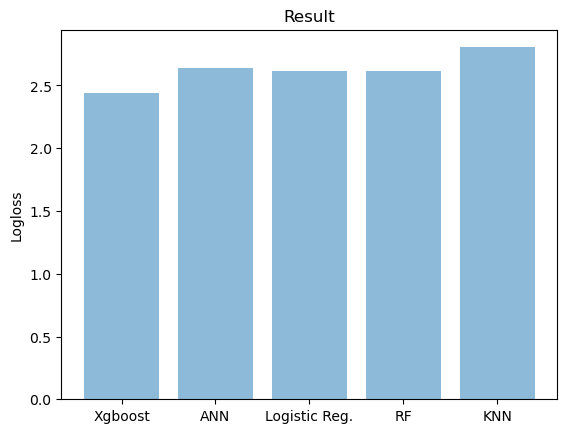

In [29]:
objects = ('Xgboost', 'ANN', 'Logistic Reg.', 'RF', 'KNN')
y_pos = np.arange(len(objects))
performance = [2.44,2.64,LogisticRegression_loss,RandomForest_loss,Knn_loss]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Logloss')
plt.title('Result')

plt.show()